# GeMpy

In [1]:
import sys
sys.path.append("../")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

In [2]:
geo_data = gp.read_pickle("../input_data/BasicFault.pickle")
geo_data.n_faults = 1

In [3]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,order_series,isFault
0,800.0,1000.0,-1600.0,MainFault,fault,1,True
1,1200.0,1000.0,-400.0,MainFault,fault,1,True
2,1100.0,1000.0,-700.0,MainFault,fault,1,True
3,900.0,1000.0,-1300.0,MainFault,fault,1,True
4,1000.0,1000.0,-1000.0,MainFault,fault,1,True


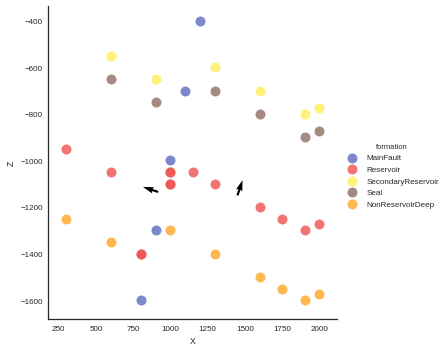

In [4]:
gp.plot_data(geo_data, direction='y')

In [5]:
# stdev for x,y,z interface coordinates
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = None
geo_data.interfaces['Z_std'] = 100
geo_data.interfaces['dist_type'] = "Normal" # should be initially None
geo_data.interfaces['X_dist'] = None
geo_data.interfaces['Y_dist'] = None
geo_data.interfaces['Z_dist'] = None

#geo_data.foliations['X_std'] = None
#geo_data.foliations['Y_std'] = 0
#geo_data.foliations['Z_std'] = 0

In [6]:
geo_data.interfaces["Z_std"] = 500

In [7]:
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

I am in the setting
float32
I am here
[2, 2]


In [8]:
sol = gp.compute_model(interp_data)

[3, 3]


adding dataframe columns for uncertainty analysis

### Create pymc.Distribution objects for each stochastic value and put into df

In [14]:
def create_priors(data, data_ref):
    """
    data = interp_data.interpolator.pandas_rest_layer_points
    data_ref = interp_data.interpolator.ref_layer_points
    """
    X_priors = np.array([])
    Y_priors = np.array([])
    Z_priors = np.array([])

    # iterate over dataframe
    for i, row in data.T.iteritems():
        if math.isnan(row["X_std"]):
            X_priors = np.append(X_priors, row["X"])
        else:
            dist = pymc.Normal("X_" + str(i), row["X"], 1 / row["X_std"] ** 2)
            X_priors = np.append(X_priors, dist)

        if math.isnan(row["Y_std"]):
            Y_priors = np.append(Y_priors, row["Y"])
        else:
            dist = pymc.Normal("Y_" + str(i), row["Y"], 1 / row["Y_std"] ** 2)
            Y_priors = np.append(Y_priors, dist)

        if math.isnan(row["Z_std"]):
            Z_priors = np.append(Z_priors, row["Z"])
        else:
            dist = pymc.Normal("Z_" + str(i), row["Z"], 1 / row["Z_std"] ** 2)
            Z_priors = np.append(Z_priors, dist)
    
    # ///////////////////////////////////////////////////////////////////////////////////
    # take care of ref values
    for fmt in np.unique(data["formation"].values):
        f = np.where(data["formation"].values == fmt)[0]
        #print(fmt+":",f)
        #print(ref_z[f[0]:f[-1]+1])
        data_ref[:,0][f[0]:f[-1]+1] = X_priors[f[0]]
        data_ref[:,1][f[0]:f[-1]+1] = Y_priors[f[0]]
        data_ref[:,2][f[0]:f[-1]+1] = Z_priors[f[0]]
    
    # ///////////////////////////////////////////////////////////////////////////////////
    return X_priors, Y_priors, Z_priors, data_ref  #, index

In [15]:
X_priors, Y_priors, Z_priors, data_ref = create_priors(interp_data.interpolator.pandas_rest_layer_points, interp_data.interpolator.ref_layer_points)

### Create pymc.Model

In [13]:
Z_rest = pymc.Normal('Z_unc',  interp_data.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'))

Z_ref = pymc.Normal('Z_unc',  interp_data.interpolator.pandas_ref_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_ref_layer_points['Z_std'].as_matrix().astype('float32'))

In [14]:
i = interp_data.get_input_data()

[3, 3]


In [15]:
@pymc.deterministic
def gempy_model(value=0, input_ =  i, Z_rest_m = Z_rest, Z_ref_m = Z_ref):
          #xp = X_priors, yp = Y_priors, zp = Z_priors, ref = data_ref):
    
    # set data to fixed and/or prior draws
    #interp_data.interpolator.pandas_rest_layer_points["X"] = xp
    #interp_data.interpolator.pandas_rest_layer_points["Y"] = yp
    #interp_data.interpolator.pandas_rest_layer_points["Z"] = zp
    # set ref values accordingly
    #interp_data.interpolator.ref_layer_points = data_ref
    # print(interp_data.interpolator.pandas_rest_layer_points["Z"].values)
    # compute model
    #print(input_)
    print(Z_rest_m)
    i[4][:, 2] = Z_ref_m
    i[5][:, 2] = Z_rest_m
    
    sol = interp_data.th_fn(*input_)
    # return solution
    return sol

[-0.07882348  0.1816738   0.65331517  0.3198098   0.60544731  0.38470313
  0.62108657  0.57610506  0.22367794  0.24177635  0.60528518  1.15988415
  0.40820467  0.69040109  0.59663142  0.82711956  0.90117814  0.68267933
  0.43564997  0.64687274  0.69874035 -0.18489831  0.42275629 -0.23127259
  0.31045478  0.4224224   0.70844848  0.1256047   0.08316921  0.60441598
  0.25736579 -0.0444082   1.09588699  0.54188184]


In [137]:
# set number of iterations
iterations = 10

In [138]:
# params = []
# for p in X_priors:
#     if type(p) != np.float64:
#         params.append(p)
# for p in Y_priors:
#     if type(p) != np.float64:
#         params.append(p)
# for p in Z_priors:
#     if type(p) != np.float64:
#         params.append(p)
# params.append(gempy_model)

# set model
pymc_model = pymc.Model(Z_ref, Z_rest, gempy_model)

### MCFS

In [139]:
MCFS_RUN = pymc.MCMC(pymc_model)
MCFS_RUN.sample(iter=iterations)

[ 0.65393005  0.57723444  0.42315912  0.50004208  0.42942778  0.42288035
  0.47429265  0.48727626  0.44889721  0.43580528  0.48723212  0.47438269
  0.48702199  0.47432585  0.39742204  0.39768321  0.48735782  0.61557094
  0.60276405  0.55126327  0.57711512  0.55778166  0.57703897  0.55139665
  0.52569559  0.53214252  0.56410341  0.4360976   0.35269061  0.39757722
  0.37196363  0.35895766  0.42331713  0.34633668]
 [-------          20%                  ] 2 of 10 complete in 2.1 sec[ 0.65403164  0.57692383  0.4232099   0.50013068  0.4295788   0.42317175
  0.47441635  0.48738221  0.44885276  0.43596583  0.48722692  0.47444814
  0.48732716  0.47442162  0.3975909   0.39768611  0.48724338  0.61552686
  0.60266195  0.55124522  0.57699373  0.55774242  0.5770234   0.5513124
  0.52558966  0.53211239  0.56424934  0.43600582  0.35296228  0.39742366
  0.37205092  0.35897778  0.42307689  0.34619627]
 [-----------      30%                  ] 3 of 10 complete in 4.0 sec[ 0.6538665   0.57704397  0.42323

In [127]:
import matplotlib.pyplot as plt

In [128]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [129]:
def p(i):
    ax.imshow(MCFS_RUN.trace("gempy_model", chain=-1)[i][0, 0, :].reshape(50,50,50)[:,24,:].T, origin="lower")

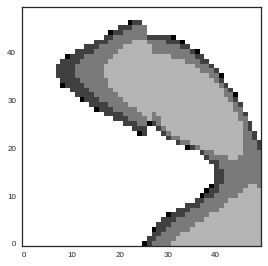

In [130]:
fig, ax = plt.subplots()
interact(p, i=widgets.IntSlider(min=0, max=9, step=1, value=0));

In [112]:
MCFS_RUN.trace("gempy_model", chain=-1)[0][0]

array([[ 2.        ,  2.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03737294, -0.03730883, -0.03726807, ..., -0.14511564,
        -0.14736997, -0.1495508 ],
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

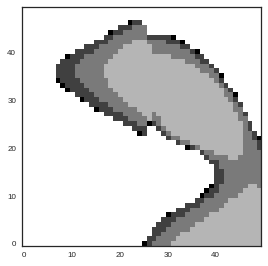

In [135]:
plt.imshow(MCFS_RUN.trace("gempy_model", chain=-1)[6][0, 0, :].reshape(50,50,50)[:,24,:].T, origin="lower")